## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP1 INF8460 <br>  Automne 2021 </center>

## 1. DESCRIPTION
Dans ce TP, l’idée est d’effectuer de la recherche de passages de texte dans un corpus à partir d’une question en langue naturelle. Les questions et passages sont en anglais.

Voici un exemple : <br>
__Entrée : Question :__ What causes precipitation to fall?  

__Solution - Trouver un passage qui contient la réponse à la question :__ In meteorology, precipitation is any product of the condensation of atmospheric water vapor that falls under <mark> __gravity__ </mark>. The main forms of precipitation include drizzle, rain, sleet, snow, graupel and hail... Precipitation forms as smaller droplets coalesce via collision with other rain drops or ice crystals within a cloud. Short, intense periods of rain in scattered locations are called “showers”. 

Ici la réponse est en gras dans le texte.

## 2. LIBRARIES PERMISES
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- Pour toute autre librairie, demandez à votre chargé de laboratoire


## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)

## 4. DESCRIPTION DES DONNEES

Dans ce projet, vous utiliserez le jeu de données dans le répertoire _data_. Il est décomposé en données d’entrainement (train), de validation (dev) et de test (test). <br>

Nous ne mettrons à votre disposition que les données d’entrainement et de validation. Les données de test ne contiennent pas le paragraphe de réponse et doivent être complétées avec les résultats de votre système.
Nous vous fournissons un ensemble de données qui comprend un corpus (_corpus.csv_) qui contient tous les passages et leurs identificateurs (ID) et un jeu de données qui associe une question, un passage, et une réponse qui est directement extraite du passage. Notez que certains passages contiennent des balises HTML et qu’il vous faudra procéder à un prétraitement de ces passages pour les enlever. <br>
Ce jeu de données est composé de trois sous-ensembles : 
- _Train_ : ensemble d’entraînement de la forme <QuestionID, QuestionText, PassageID, Réponse>. Le but est donc d’entrainer votre modèle à retrouver le passage qui contient la réponse à la question.
- _Validation_ : De la même forme que le Train, il vous permet de valider votre entraînement et de tester les performances de certains modules.  
- _Test_ : Un ensemble secret qui est utilisé pour évaluer votre système complet. Il est de la forme <QuestionID, Question>. Votre système doit trouver dans le corpus __corpus.csv__ le ou les passages les plus pertinents.

Notez qu’il est possible de répondre aux requis du TP sans utiliser la réponse à la question. C’est à vous de choisir si vous utilisez la réponse ou non. 

In [40]:
# Installation de l'intégralité des packages
conda install requirements.txt


Note: you may need to restart the kernel to use updated packages.Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



PackagesNotFoundError: The following packages are not available from current channels:

  - requirements.txt

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.


## 5. ETAPES DU TP 
A partir du notebook _inf8460_A21_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Noter que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

Ci-dessous définir la constante _PATH_ qui doit être utilisée par votre code pour accéder aux fichiers. Il est attendu que pour la correction, le chargé de lab n'ait qu'à changer la valeur de _PATH_ pour le répertoire où se trouver les fichiers de datasets.

In [1]:
PATH = "data/"

In [67]:
#Taille du vocabulaire 
N = 3000

In [57]:
import pandas
import nltk
import string
import re
import math 
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/elalemdy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elalemdy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elalemdy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
# Lecture des dataframes utiles au TP
data_corpus = pandas.read_csv(PATH + "corpus.csv")
data_questions = pandas.read_csv(PATH + "train_ids.csv")
data_validation = pandas.read_csv(PATH + "val_ids.csv")
data_validation_reduced = pandas.read_csv(PATH + "val_reduced.csv")
#data_test = pandas.read_csv(PATH + "test.csv")
#data_test_reduced = pandas.read_csv(PATH + "test_reduced.csv")

### 5.1. Pré-traitement (12 points)
Les passages et questions de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de passage pour répondre à une question. On vous demande donc d’implémenter une étape de pré-traitement des données.
1) (_6 points_) Complétez les fonctions retournant les informations suivantes (une fonction par information, chaque fonction prenant en argument le corpus (passages, questions) composé d'une liste de phrases segmentées en jetons/tokens) :
    1. Le nombre total de jetons (mots non distincts)
    2. Le nombre total de mots distincts (les types qui constituent le vocabulaire)
    3. Les N mots les plus fréquents du vocabulaire (N est un paramètre avec une valeur par défaut de 10) ainsi que leur fréquence
    4. Le ratio jeton/type
    5. Le nombre total de lemmes distincts
    6. Le nombre total de racines (stems) distinctes

In [5]:
#Un exemple simple pour vérifier l'efficacité des fonctions définies ci-dessous
corpus_example = [["banana", "bananas", "banana", "wolves", "wolf"], ["hello", "you", "are", "my", "friend"]]

In [43]:
def count_tokens(corpus) :
    #Compte le nombre de mots
    counter = 0
    for element in corpus :
        counter += len(element)
    return counter

def count_types(corpus) :
    #Compte le nombre de mots distincts
    set_of_words = set()
    for sentence in corpus :
        for word in sentence : 
            set_of_words.add(word)
    return len(set_of_words)

def count_most_frequent_tokens(corpus, n):
    #Repère les mots les plus fréquents et les retourne avec leurs fréquences d'apparitions associées
    tokens = defaultdict(lambda: 0)
    for text in corpus:
        for word in text:
            tokens[word] += 1
    
    tokens = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
    return tokens[0:n]

def ratio_token_type(corpus):
    return count_tokens(corpus) / count_types(corpus)

def count_lemmas(corpus):
    #Compte le nombre de mots distincts après lemmatisation
    lemmzer = WordNetLemmatizer()
    tokens = set()
    for text in corpus:
        for word in text:
            tokens.add(lemmzer.lemmatize(word))
    return len(tokens)

def count_stems(corpus):
    #Compte le nombre de mots distincts après stemmatization
    stemmer = PorterStemmer()
    tokens = set()
    for text in corpus:
        for word in text:
            tokens.add(stemmer.stem(word))
    return len(tokens)

2. (_1 point_) Ecrivez une fonction explore_corpus() qui fait appel à toutes les fonctions en 1) et imprime leur résultat.


In [49]:
def explore_corpus(corpus):
    print("Le nombre total de jetons: ", count_tokens(corpus))
    print("Le nombre total de mots distincts: ", count_types(corpus))
    print("Les N mots les plus fréquents du vocabulaires: ", count_most_frequent_tokens(corpus, N))
    print("Le ratio jeton/type: ", round(ratio_token_type(corpus),2))
    print("Le nombre total de racines (stems) distinctes: ", count_stems(corpus))
    print("Le nombre total de lemmes distincts: ", count_lemmas(corpus))

In [51]:
# Statistiques pour notre exemple de corpus
explore_corpus(corpus_example)

Le nombre total de jetons:  10
Le nombre total de mots distincts:  9
Les N mots les plus fréquents du vocabulaires:  [('banana', 2), ('bananas', 1), ('wolves', 1), ('wolf', 1), ('hello', 1), ('you', 1), ('are', 1), ('my', 1), ('friend', 1)]
Le ratio jeton/type:  1.11
Le nombre total de racines (stems) distinctes:  8
Le nombre total de lemmes distincts:  7


3. (_5 points_) Pour la suite du TP, vous devez effectuer le pré-traitement du corpus (questions, passages) en convertissant le texte en minuscules, en segmentant le texte, en supprimant les mots outils et en lemmatisant le texte. Chaque opération doit avoir sa fonction python si elle n’est pas déjà implantée dans la question 1) précédente.

In [6]:
def clean_html(text) :
    #Enlève les tags html d'un texte
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext

def remove_punctuation(text) :
    return re.sub(r'[^\w\s]','',text)

def tokenize_text(text):
    return nltk.word_tokenize(text.lower().strip())

def remove_small_words(tokens, min_length) :
    # From a list of tokens, remove the tokens which size are smaller than a given threshold min_length
    for word in tokens :
        if len(word) < min_length :
            tokens.remove(word)
    return tokens

def remove_stopwords(tokens):
    return [word for word in tokens if not word in stopwords.words('english')]

def lemmatize_tokens(tokens) :
    lemmzer = WordNetLemmatizer()
    return [lemmzer.lemmatize(word) for word in tokens]

def text_preprocessor(text) :
    #Fonction qui trasnforme une phrase en vecteur de mots processés
    text_clean = remove_punctuation(clean_html(text))
    tokens = tokenize_text(text_clean)
    clean_tokens = remove_small_words(lemmatize_tokens(remove_stopwords(tokens)),4)
    return " ".join(clean_tokens)

def preprocessing(df, column) :
    #Transforme une dataframe contenant du texte pour une colonne donnée en une nouvelle dataframe avec une colonne en plus
    #de ce texte processé
    data = df[column].apply(text_preprocessor)
    data_copy = data.copy()
    data_copy["processed"] = data
    return data_copy

### 5.2. Représentation de questions et de passages (14 points)

1. (_10 points_) En utilisant sklearn et à partir de votre corpus pré-traité, vous devez implanter un modèle M1 qui est de représenter chaque passage et question avec votre vocabulaire, en utilisant un modèle sac de mots des n-grammes (n=1) qu’ils contiennent et en pondérant ces éléments avec TF-IDF. Notez que les questions doivent aussi être inclues dans la construction du vocabulaire.

In [52]:
# Index utilisé pour couper la taille de nos datasets d'entrainements de corpus et de questions
index_to_cut = 1000

In [78]:
# Pré-traitement du corpus, des questions d'entrainement et de l'ensemble de validation
processed_corpus = preprocessing(data_corpus[0:index_to_cut], "paragraph")
processed_questions = preprocessing(data_questions[0:index_to_cut], "question")
processed_validation = preprocessing(data_validation, "question")

In [54]:
def tf_idf(processed_questions, processed_corpus, N, n_grams) :
    #A partir des dataframes pré-traités de questions et de paragraphes, d'une taille de vocabulaire N et 
    #d'un couple n_grams, renvoie une matrice TF-IDF ainsi que son vectorizer associé
    vectorizer = TfidfVectorizer(smooth_idf=False, max_features = N, ngram_range = n_grams)
    vectorizer.fit(pandas.concat([processed_questions["processed"], processed_corpus["processed"]], ignore_index = True))
    tfidf_corpus = vectorizer.transform(processed_corpus["processed"]) 
    print("Vocabulary :" + "\n\n", vectorizer.get_feature_names())
    return tfidf_corpus, vectorizer

In [55]:
# Exemple pour le premier modèle avec affichage du vocabulaire
tfidf_M1, vectorizer_M1 = tf_idf(processed_questions, processed_corpus, N, (1,1))

Vocabulary :

 ['academic', 'according', 'across', 'addition', 'algorithm', 'almost', 'along', 'also', 'although', 'amazon', 'america', 'american', 'among', 'amount', 'angeles', 'animal', 'another', 'antigen', 'area', 'around', 'article', 'author', 'average', 'back', 'based', 'basis', 'became', 'become', 'began', 'bill', 'black', 'body', 'book', 'branch', 'british', 'bskyb', 'building', 'built', 'business', 'california', 'called', 'campus', 'capital', 'case', 'cause', 'caused', 'cell', 'center', 'central', 'century', 'change', 'channel', 'chicago', 'china', 'chinese', 'church', 'city', 'civil', 'claim', 'class', 'climate', 'college', 'commission', 'committee', 'common', 'community', 'company', 'complexity', 'computer', 'considered', 'construction', 'cost', 'could', 'council', 'country', 'county', 'court', 'created', 'ctenophore', 'culture', 'current', 'cycle', 'cylinder', 'data', 'date', 'death', 'decision', 'design', 'developed', 'development', 'different', 'direct', 'directive', 'dir

2. (_4 points_) Expérimentez maintenant avec un modèle n-gramme (n=1,2) mélangeant les unigrammes et les bigrammes et pondéré avec TF-IDF.

In [56]:
# Exemple pour le second modèle avec affichage du vocabulaire
tfidf_M2, vectorizer_M2 = tf_idf(processed_questions, processed_corpus, N, (1,2))

Vocabulary :

 ['academic', 'according', 'across', 'addition', 'algorithm', 'almost', 'along', 'also', 'although', 'amazon', 'america', 'american', 'among', 'angeles', 'animal', 'another', 'antigen', 'area', 'around', 'article', 'author', 'average', 'based', 'basis', 'became', 'become', 'began', 'bill', 'black', 'body', 'branch', 'british', 'bskyb', 'building', 'built', 'business', 'california', 'called', 'campus', 'capital', 'case', 'cause', 'caused', 'cell', 'center', 'central', 'century', 'change', 'channel', 'chicago', 'china', 'chinese', 'church', 'city', 'civil', 'civil disobedience', 'claim', 'class', 'climate', 'college', 'commission', 'committee', 'common', 'community', 'company', 'complexity', 'considered', 'construction', 'cost', 'could', 'council', 'country', 'county', 'court', 'court justice', 'created', 'ctenophore', 'culture', 'current', 'cycle', 'cylinder', 'data', 'date', 'death', 'decision', 'design', 'developed', 'development', 'different', 'direct', 'directive', 'di

Pour M1 et M2, assurez-vous de réutiliser la même fonction avec comme paramètre les n-grammes à considérer.

### 5.3. Ordonnancement des passages (10 points)
Maintenant que vous avez une représentation de vos passages et questions, il faut être capable de déterminer quel passage sera le plus pertinent pour la question posée. Il vous faut donc retrouver un top-N (N=1,5,10 … ) de passages utiles pour répondre à la question. Ces passages devront être ordonnés du plus pertinent au moins pertinent. Idéalement le passage à la position 1 sera celui qui contient la réponse à la question.
<br>
<br>
Vous devez écrire des fonctions pour évaluer la similarité entre la représentation de la question et celle de chaque passage et retourner les N passage les plus similaires où N est un paramètre. 
1. (_5 points_) En utilisant la distance euclidienne


In [57]:
#Valeur top-N définie par défaut
top_N = 10

In [79]:
def process_question(question, vectorizer) :
    #A partir d'une question au format string et d'un vectorizer, renvoie un vecteur après pré-traitement
    #et vectorisation de la question
    preprocessed_question = [text_preprocessor(question)]
    return vectorizer.transform(preprocessed_question)

In [80]:
#Un exemple d'application pour le premier modèle
tfidf_question_M1 = process_question("Which section of the Rhine is most factories found?", vectorizer_M1)

In [85]:
tfidf_question_M1

<1x400 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [82]:
#Un exemple d'application pour le premier modèle
tfidf_question_M2 = process_question("Which section of the Rhine is most factories found?", vectorizer_M2)

In [83]:
tfidf_question_M2

<1x400 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [63]:
def question_answer(tfidf_question, tfidf_corpus, data_corpus, distance, top_N) :
    #A partir d'une question vectorisé, d'un corpus vectorisé, des données du corpus initial, d'une 
    #métrique de distance donnée et d'une valeur top-N, renvoie les top-N réponses à la question
    distances = distance(tfidf_question, tfidf_corpus)[0]
    data_corpus_copy = data_corpus.copy()
    data_corpus_copy["distance"] = distances
    sorted_data_corpus = data_corpus_copy.sort_values(by='distance')
    return sorted_data_corpus[0:top_N]

In [98]:
#Exemple de réponses pour le premier modèle et la distance euclidienne
question_answer(tfidf_question_M1, tfidf_M1, data_corpus[0:index_to_cut], euclidean_distances, 1000)

,id,paragraph,distance
942,942,Germanic tribes crossed the Rhine in the Migra...,0.795485
912,912,"The Rhine emerges from Lake Constance, flows g...",0.888353
918,918,The dominant economic sectors in the Middle Rh...,0.906364
913,913,"In the centre of Basel, the first major city i...",0.922175
906,906,The length of the Rhine is conventionally meas...,0.928311
...,...,...,...
360,360,Free movement of goods within the European Uni...,1.414214
863,863,These studies were widely presented as demonst...,1.414214
508,508,"The addition of new rock units, both depositio...",1.414214
182,182,The Catholic Church in France and many of its ...,1.414214


In [ ]:
#Exemple de réponses pour le second modèle et la distance euclidienne
question_answer(tfidf_question_M2, tfidf_M2, data_corpus[0:index_to_cut], euclidean_distances, top_N)

2. (_5 points_) En utilisant la distance cosinus

In [86]:
#Exemple de réponses pour le premier modèle et la distance cosinus
question_answer(tfidf_question_M1, tfidf_M1, data_corpus[0:index_to_cut], cosine_distances, top_N)

,id,paragraph,distance
942,942,Germanic tribes crossed the Rhine in the Migra...,0.316398
912,912,"The Rhine emerges from Lake Constance, flows g...",0.394586
918,918,The dominant economic sectors in the Middle Rh...,0.410748
913,913,"In the centre of Basel, the first major city i...",0.425204
906,906,The length of the Rhine is conventionally meas...,0.430880
915,915,The Rhine is the longest river in Germany. It ...,0.435433
922,922,"The name Rijn, from here on, is used only for ...",0.457842
923,923,"The Rhine-Meuse Delta, the most important natu...",0.470646
946,946,"In World War II, it was recognised that the Rh...",0.474752
930,930,"Through stream capture, the Rhine extended its...",0.477975


In [87]:
#Exemple de réponses pour le second modèle et la distance cosinus
question_answer(tfidf_question_M2, tfidf_M2, data_corpus[0:index_to_cut], cosine_distances, top_N)

,id,paragraph,distance
942,942,Germanic tribes crossed the Rhine in the Migra...,0.316398
912,912,"The Rhine emerges from Lake Constance, flows g...",0.394586
918,918,The dominant economic sectors in the Middle Rh...,0.401609
913,913,"In the centre of Basel, the first major city i...",0.422112
906,906,The length of the Rhine is conventionally meas...,0.430880
915,915,The Rhine is the longest river in Germany. It ...,0.435433
922,922,"The name Rijn, from here on, is used only for ...",0.457842
946,946,"In World War II, it was recognised that the Rh...",0.468657
923,923,"The Rhine-Meuse Delta, the most important natu...",0.470646
930,930,"Through stream capture, the Rhine extended its...",0.477975


### 5.4. Évaluation (15 points)
En utilisant votre ensemble de validation : <br>
1. (_5 points_) Vous devez calculer la précision top-N (N=1,5,10, 50) de votre modèle M1 et M2 avec la distance euclidienne et cosinus et les afficher. 


In [94]:
def compute_precision(data_val, data_corpus, vectorizer, distance, tfidf, top_N) :
    #A partir des datasets de validation et du corpus, d'une matrice tf-idf et de son vectorizer associé, d'une métrique de
    #distance et d'une valeur top-N, renvoie la précision top-N pour l'ensemble des questions
    count_good_answers = 0
    for i in range(len(data_val)) :
        raw_question = data_val["question"][i]
        tfidf_question = process_question(raw_question, vectorizer)
        paragraph_id_answer = data_val["paragraph_id"][i]
        indexes_top_N = question_answer(tfidf_question, tfidf, data_corpus, distance, top_N)["id"]
        if paragraph_id_answer in(indexes_top_N) :
            count_good_answers += 1
    return round(count_good_answers/len(data_val)*100,2)

In [89]:
#Calcul de la précision pour le premier modèle et la distance euclidienne 
precision_euclidean_M1 = compute_precision(data_validation, data_corpus[0:index_to_cut], vectorizer_M1, euclidean_distances, tfidf_M1, top_N)

In [90]:
#Calcul de la précision pour le second modèle et la distance euclidienne 
precision_euclidean_M2 = compute_precision(data_validation, data_corpus[0:index_to_cut], vectorizer_M2, euclidean_distances, tfidf_M2, top_N)

In [91]:
#Calcul de la précision pour le premier modèle et la distance cosinus 
precision_cosine_M1 = compute_precision(data_validation, data_corpus[0:index_to_cut], vectorizer_M1, cosine_distances, tfidf_M1, top_N)

In [92]:
#Calcul de la précision pour le second modèle et la distance cosinus 
precision_cosine_M2 = compute_precision(data_validation, data_corpus[0:index_to_cut], vectorizer_M2, cosine_distances, tfidf_M2, top_N)

In [93]:
print("For the first model and the euclidean distance, the precision is about", precision_euclidean_M1, "%")
print("For the second model and the euclidean distance, the precision is about", precision_euclidean_M2, "%")
print("For the first model and the cosine distance, the precision is about", precision_cosine_M1, "%")
print("For the second model and the cosine distance, the precision is about", precision_cosine_M2, "%")

For the first model and the euclidean distance, the precision is about 0.56 %
For the second model and the euclidean distance, the precision is about 0.54 %
For the first model and the cosine distance, the precision is about 0.56 %
For the second model and the cosine distance, the precision is about 0.54 %


2. (_5 points_) Pour chacun de ces modèles, générez une courbe de performance faisant varier le N (N=1, 5, 10, 50)

In [27]:
#Liste des top-N 
tops_N = [1, 5, 10, 50]

In [95]:
def generate_plot(data_val, data_corpus, vectorizer, distance, tfidf, tops_N, model_name, distance_name) :
    #Fonction qui trace l'évolution de la précision en fonction de la valeur top-N pour un modèle et une distance donnée 
    precisions = []
    for current_N in tops_N :
        precision = compute_precision(data_val, data_corpus, vectorizer, distance, tfidf, current_N)
        precisions.append(precision)
    plt.plot(tops_N, precisions, label = "Distance " + distance_name)
    plt.legend()

KeyboardInterrupt: 

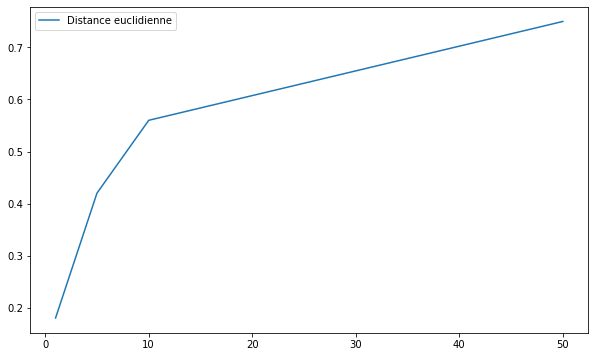

In [103]:
#Défini la taille de la figure
fig = plt.figure(1, figsize=(10, 6))

#Trace les deux courbes pour le modèle M1
generate_plot(data_validation, data_corpus[0:index_to_cut], vectorizer_M1, euclidean_distances, tfidf_M1, tops_N, "M1", "euclidienne")
generate_plot(data_validation, data_corpus[0:index_to_cut], vectorizer_M1, cosine_distances, tfidf_M1, tops_N, "M1", "cosinus")

#Légende
plt.xlabel("N")
plt.ylabel("Précision (%)")
plt.title("Précision top-N pour le modèle M1")
plt.show()

Text(0.5, 1.0, 'Précision top-N pour le modèle M2')

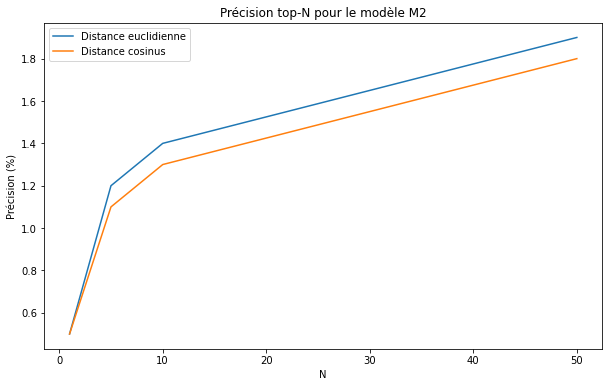

In [97]:
#Défini la taille de la figure
fig = plt.figure(1, figsize=(10, 6))

#Trace les deux courbes pour le modèle M2
generate_plot(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M2, euclidean_distances, tfidf_M2, tops_N, "M2", "euclidienne")
generate_plot(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M2, cosine_distances, tfidf_M2, tops_N, "M2", "cosinus")

#Légende
plt.xlabel("N")
plt.ylabel("Précision (%)")
plt.title("Précision top-N pour le modèle M2")

3. (_5 points_) A cette étape, vous devez produire un fichier _passage_submission_M1.csv_ et _passage_submission_M2.csv_ qui contient pour toutes les questions de l’ensemble de test le top-N des passages retournés par votre modèle M1 et M2 pour y répondre. C’est à vous de déterminer si vous utiliserez la distance euclidienne ou cosinus basé sur vos résultats d’évaluation sur l’ensemble de validation en 1) et 2). Le fichier doit respecter le format suivant pour chaque top_N(N=1,5,10,50) :  <QuestionID, PassageID1 ;… ;PassageIDN>. Le format est démontré dans _sample_passage_submission.csv_.

In [100]:
def generate_submission_file(data_questions, data_corpus, vectorizer, chosen_distance, tfidf, tops_N, model_name, write = True) :
    #A partir des datasets de questions/corpus, d'un modèle donnée avec une distance choisie, créer le fichier
    #passage_submission
    
    #Création d'une dataframe vide au format demandé
    df_columns = ["id"] + ["top_" + str(current_N) for current_N in tops_N]
    output_df = pandas.DataFrame(columns = df_columns)
    
    max_N = max(tops_N)
    for i in range(len(data_questions)) :
        raw_question = data_questions["question"][i]
        id_question = data_questions["id"][i]
        element_to_add = [id_question]
        tfidf_question = process_question(raw_question, vectorizer)
        indexes_top_N = list(map(lambda x: str(x), question_answer(tfidf_question, tfidf, data_corpus, chosen_distance, max_N).index.to_list()))
        
        #Plutôt que de recalculer les top-N réponses à chaque fois, on calcule sur le plus grand top-N et on split la liste
        for current_N in tops_N :
            elm = ";".join(indexes_top_N[0:current_N])
            element_to_add.append(elm)
            
        output_df = output_df.append(pandas.DataFrame([element_to_add], columns = df_columns))
        
    output_df = output_df.set_index("id")
    if write :
        output_df.to_csv("passage_submission_" + model_name + ".csv")
    return output_df

In [101]:
#Création du fichier de passage pour M1
output_df_M1 = generate_submission_file(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M1, euclidean_distances, tfidf_M1, tops_N, "M1")

In [77]:
#Création du fichier de passage pour M2
output_df_M2 = generate_submission_file(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M2, euclidean_distances, tfidf_M2, tops_N, "M2")

### 5.5. Le plus (24 points)

1. (_21 points_) Vous devez proposer un modèle M3 différent (basé sur l’apprentissage machine par exemple) afin de déterminer un score de pertinence d’un passage pour une question donnée et ordonner les passages. 
    - Faites une petite recherche sur l’état de l’art en consultant https://nlp.stanford.edu/IR-book/information-retrieval-book.html
    - Vous êtes libres de proposer une autre métrique de poids, ou une autre façon d’ordonner les passages (exemple : méthodes de type _learning to rank_) et de partir de votre corpus initial ou de votre ordonnancement en M1/M2 (choisissez le meilleur) et de réordonnancer les passages obtenus par votre premier modèle.
    - Expliquez votre modèle et son intérêt dans votre notebook. Le nombre de points obtenus dépendra de l’effort mis dans cette partie.

In [ ]:
from sklearn.metrics import confusion_matrix

X_train = vectorizer_M1.transform(processed_questions["processed"]).toarray()
y_train = data_questions[0:index_to_cut]["paragraph_id"]
X_valid = vectorizer_M1.transform(preprocessing(data_validation[0:10], "question")["processed"]).toarray()
y_valid = data_validation["paragraph_id"][0:10]

from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 20).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_valid)
dtree_predictions

#from sklearn.svm import SVC
#svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
#svm_predictions = svm_model_linear.predict(X_valid)

#from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
#knn_predictions = knn.predict(X_valid)

#from sklearn.naive_bayes import GaussianNB
#gnb = GaussianNB().fit(X_train, y_train)
#gnb_predictions = gnb.predict(X_valid)

print(y_valid)
dtree_predictions

In [104]:
def is_it_the_good_answer(answer_id, right_id) :
    if answer_id == right_id :
        return 1
    else :
        return 0

In [112]:
def create_training_dataframe(data_questions, data_corpus, vectorizer, chosen_distance, tfidf, top_N) :
    list_of_X = []
    list_of_Y = []
    for i in range(len(data_questions)) :
        raw_question = data_questions["question"][i]
        tfidf_question = process_question(raw_question, vectorizer)
        paragraph_id_answer = data_questions["paragraph_id"][i]
        answers = question_answer(tfidf_question, tfidf, data_corpus, chosen_distance, top_N)
        Yi = pandas.DataFrame(answers["id"].apply(lambda x: int(x==paragraph_id_answer)))
        Xi = pandas.DataFrame(answers["distance"])
        list_of_X.append(Xi)
        list_of_Y.append(Yi)
    X = pandas.concat(list_of_X)
    Y = pandas.concat(list_of_Y)
    return X, Y

In [ ]:
X, Y = create_training_dataframe(data_questions, data_corpus[0:index_to_cut], vectorizer_M1, euclidean_distances, tfidf_M1, 50)

In [ ]:
from sklearn.linear_model import RandomForestClassifier

def train_model(X, Y) :
    model = RandomForestClassifier()
    model.fit(X,Y)
    return model

In [ ]:
randomforest_model = train_model(X, Y)

In [ ]:
def question_answer_M3(tfidf_question, tfidf_corpus, data_corpus, distance, top_N, model) : 
    answers = question_answer(tfidf_question, tfidf_corpus, data_corpus, distance, top_N*2)
    ypred = randomforest_model.predict(answers["distance"])
    concated_df = pandas.concat([answers,ypred], axis=0, ignore_index=True)
    

2. (_2  point_) Vous devez ensuite afficher l’évaluation de votre modèle M3 tel que décrit dans la section 5.4 Evaluation en utilisant les mêmes fonctions. Notamment, vous devez comparer les performances de vos modèles M1, M2 et M3 sur l’ensemble de validation avec une courbe de performance faisant varier le N (N=1, 5, 10, …)

3. (_1 point_) En utilisant votre modèle M3, vous devez produire un fichier passage_submission_M3.csv qui contient pour toutes les questions de l’ensemble de test le top-N des passages retournés par votre système pour y répondre. Le fichier doit respecter le format suivant pour chaque top_N (N=1,5,10,50) :  <QuestionID, PassageID1…PassageIDN>. _Le format est démontré dans sample_passage_submission.csv_

## LIVRABLES
Vous devez remettre sur Moodle:
1. _Le code_ : Un Jupyter notebook en Python qui contient le code implanté avec les librairies permises. Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière à expliquer les différentes fonctions et étapes dans votre projet. Nous nous réservons le droit de demander une démonstration ou la preuve que vous avez effectué vous-mêmes les expériences décrites. _Attention, en aucun cas votre code ne doit avoir été copié d’une quelconque source_. Les critères de qualité tels que la lisibilité du code et des commentaires sont importants. Tout votre code et vos résultats doivent être exécutables et reproductibles ; 
2. Un fichier _requirements.txt_ doit indiquer toutes les librairies / données nécessaires ;
3. Un lien _GoogleDrive_ ou similaire vers les modèles nécessaires pour exécuter votre notebook si approprié ;
4. Les fichiers de soumission de données de test _passage_submission_M1.csv_ et _passage_submission_M2.csv_
5. Un document _contributions.txt_ : Décrivez brièvement la contribution de chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. En particulier, tous les membres du projet devraient participer à la conception du TP et participer activement à la réflexion et à l’implémentation du code.

## EVALUATION 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code
2. Performance correcte des modèles
3. Organisation du notebook
4. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
5. Commentaires clairs et informatifs

## CODE D’HONNEUR
- Règle 1:  Le plagiat de code est bien évidemment interdit.
- Règle 2: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- Règle 3:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.
